# Fundamentals of NLP

*Last updated: June 26th, 2019 by Andrew Therriault*

This notebook is designed as an introduction to the fundamental methods and tools of natural language processing. It covers many of the most common operations used in practical NLP applications, with examples provided using standard open-source code libraries in Python. These examples are designed be reused and modified for your own projects without restrictions. 

## Setting up
This section imports common libaries used in NLP projects. Most of these should be familiar to anyone with experience using Python for data analysis, but there are other libaries such as nltk that are specific to NLP applications. In many cases, users can choose to perform a given task using any of several libaries, so the choice of which to use is mainly determined based on the tradeoff between simplicity and customizability.

In [1]:
#some standard data processing and analysis libraries
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, LatentDirichletAllocation

#changing pandas viz settings
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 1000

#text processing tools
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import string


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing an open data set to work with

This section pulls data from the Food Establishment Inspections dataset from Analyze Boston, the City of Boston's open data portal (https://data.boston.gov/dataset/food-establishment-inspections). This dataset includes a plain text field for `comments`, which gives the details of a violation, as well as structured fields including `viollevel` (violation level, which ranges form one star to three stars) and  `violdesc` (the description of the violation category). The `violdesc` field provides an opportunity to build a text classification model, using that field's values as labels that can be predicted by modeling the text in `comments`.

The dataset will be pulled directly from the Analyze Boston API. For this analysis, we'll use the API (which allows for SQL filtering) to limit the dataset to inspections of eating and drinking establishments which resulted in a failure of some kind. Each row of the resulting dataset corresponds to an individual citation issued to a restaurant or bar. In many cases, a given establishment will receive multiple citations during the same inspection, but for the purpose of this analysis we will treat each row as an individual data point.

In [0]:
url = '''https://data.boston.gov/api/3/action/datastore_search_sql?sql=
          SELECT 
            * 
          FROM \"4582bec6-2b4f-4f9e-bc55-cbaa73117f4c\" 
          WHERE result = \'HE_Fail\' 
            AND licensecat = \'FS\'
          ;'''
citations = pd.DataFrame(requests.get(url).json()['result']['records']).drop('_full_text',axis=1) #dropping raw "_full_text" column

#### Exploring dataset

In [3]:
citations.sample(5)

,_id,address,businessname,city,comments,dbaname,descript,expdttm,issdttm,legalowner,licensecat,licenseno,licstatus,location,namefirst,namelast,property_id,result,resultdttm,state,statusdate,violation,violdesc,violdttm,viollevel,violstatus,zip
21092,101254,160 Milk ST,Central Wharf Co.,Boston,Old mouse droppings noted along wall in basement / Remove. A-1 exterminators are providing bi-weekly services.,None,Eating & Drinking,2019-12-31 23:59:00,2011-12-30 10:35:15,ONE 60-166 MILK STREET LP,FS,19691,Active,"(42.358689000, -71.052756000)",,CHRISTINE FREEMAN PRES.,95433,HE_Fail,2014-05-13 12:05:06,MA,None,36-6-501.11-.12,Improper Maintenance of Floors,2014-05-13 12:05:06,*,Fail,02109
28544,139421,44 Binney ST,Dana Farber Cafe,Boston,Cooked tuna holding at 120F.Bacon cheese burger at heat lamp in cafe at 110F.Grilled chicken(same location) at 115F.,None,Eating & Drinking,2011-12-31 23:59:00,2011-11-09 08:57:43,SODEXHO @ DANA FARBER CAN CER INSTITUTE,FS,18098,Inactive,"(42.337559000, -71.107079000)",,SODEXO OPERATIONS L L C,155682,HE_Fail,2008-01-23 10:16:27,MA,None,03-3-501.16(A),Cold Holding,2008-01-23 15:18:36,***,Fail,02115
30131,147274,800 Boylston ST,Dig Inn,Boston,beets 50 degrees/provide proper temperature of 41 degrees or below,None,Eating & Drinking,2019-12-31 23:59:00,2017-10-12 08:03:46,GILLETTE CAFETERIA EDWARD C. COLEMAN,FS,331777,Active,"(42.347296000, -71.081457000)",Att: Accounts Payable,Dig Inn,157244,HE_Fail,2018-02-26 10:59:51,MA,None,03-3-501.16(A),Cold Holding,2018-02-26 10:59:51,***,Fail,02199
10028,48941,250 Huntington AVE,Betty's Wok & Noodle Diner,Boston,basement storage/provide endcaps to light shields,None,Eating & Drinking,2012-12-31 23:59:00,2011-12-05 15:43:44,KAREN ALBREKTSEN,FS,21217,Inactive,"(42.342201000, -71.085030000)",,KAREN ALBREKTSEN,157713,HE_Fail,2010-10-29 10:01:35,MA,None,38-6-202.11,Fixture's not properly shielded,2010-10-29 10:01:35,*,Fail,02115
16294,74720,1636 Blue Hill AVE,Brother Deli Restaurant,Mattapan,provide a vacuum breaker at hose connection.,None,Eating & Drinking,2019-12-31 23:59:00,2012-01-05 14:09:01,PAPAS,FS,18103,Active,"(42.268244000, -71.093378000)",GEORGE,PAPAS,16341,HE_Fail,2018-11-28 11:00:30,MA,None,30-5-203.14,Cross Connection Back Siphonage Backflow,2018-11-28 11:00:30,**,Fail,02126


In [4]:
citations.violdesc.value_counts()

Non-Food Contact Surfaces Clean                                                      2352
Improper Maintenance of Walls/Ceilings                                               2334
Non-Food Contact Surfaces                                                            1960
Food Contact Surfaces Clean                                                          1873
Food Protection                                                                      1791
Improper Maintenance of Floors                                                       1775
Hand Cleaner  Drying  Tissue Signage                                                 1523
Installed and Maintained                                                             1136
Wiping Cloths  Clean  Sanitize                                                       1113
Food Contact Surfaces Design                                                         1052
Premises Maintained                                                                  1033
Equipment 

#### Filtering to top violation categories and just the columns we care about

In [5]:
top20 = citations.violdesc.value_counts()[:20].index.tolist()
cols = ['violdesc','comments']

top_citations = citations.loc[citations.violdesc.map(lambda x: x in top20),cols]

print(top_citations.violdesc.value_counts())
top_citations.sample(10)

Non-Food Contact Surfaces Clean                  2352
Improper Maintenance of Walls/Ceilings           2334
Non-Food Contact Surfaces                        1960
Food Contact Surfaces Clean                      1873
Food Protection                                  1791
Improper Maintenance of Floors                   1775
Hand Cleaner  Drying  Tissue Signage             1523
Installed and Maintained                         1136
Wiping Cloths  Clean  Sanitize                   1113
Food Contact Surfaces Design                     1052
Premises Maintained                              1033
Equipment Thermometers                           1022
Cold Holding                                     1016
Insects  Rodents  Animals                         824
Test Kit Provided                                 722
Food Container Labels                             565
Walls/Ceilings Designed Constructed Installed     563
PIC Performing Duties                             550
Dishwashng Facilities       

,violdesc,comments
9481,Improper Maintenance of Walls/Ceilings,walls and ceilings clean to remove all soil on walls and black debris
19373,Wiping Cloths Clean Sanitize,Upon inspection there was no sanitizer set up in work/prep stations.Provide proper sanitizer with wiping cloths at all work/prep stations. PIC corrected Chlorine sanitizer 50PPM
18374,Cold Holding,The sandwich refrigerator is reading 40F but the temperature is much higher on the top shelf; ravioli 48F sour cream 60F. Provide proper cold holding of 41F or below. (The refrigerator was freshly stocked so items were moved to another refrigerator)
22491,Improper Maintenance of Floors,
872,Installed and Maintained,Pipe under the hand sink near the front service line leaking. Address and make any necessary repairs. Drain from the hot water booster apears to be draining onto the main kitchen floor. Address.
7456,Hand Cleaner Drying Tissue Signage,Provide soap and paper towels as dis cussed
28117,Food Contact Surfaces Clean,clean can opener blade
5153,Improper Maintenance of Walls/Ceilings,The walls are soiled with dust and food debris. Clean. The walk-in refrigerator compressor is dusty. Clean.
18707,Equipment Thermometers,Provide visible thermometers where necessary.
11713,Hand Cleaner Drying Tissue Signage,No paper towels at bar hand sink.PIC provided


## Trying out some initial preprocessing options
In this section, we'll explore some of the options for preprocessing the text before turning it into features. To start, we'll convert all the text to lowercase to make everything below not case sensitive. Will also fix a couple cases of having no spaces after a period and make sure slashes have spaces around them.

In [6]:
print(top_citations.comments.head(10))

0                                                                      Provide glass storage rack.
1     Provide dish rack over 3 bay sink to replace missing drainboards at each end of  3 bay sink.
2                                                        Provide dish washer at ware washing area.
3                                                                    Provide mop sink at basement.
4                                                               No hand sink at Bar Area  provide.
5                                              Provide door and finish miscellaneous storage room.
6                                                        Provide dish washer at ware washing area.
8                                                           Replace heavily scorded cutting board.
9                                                               Dishmachine not operating  repair.
10                                                 Provide sink plugs for sink behind service bar.
Name: comm

In [7]:
top_citations['comments'] = top_citations.comments.str.lower().str.replace('.','. ').str.replace('/',' / ').str.replace('  ',' ')
print(top_citations.comments.head(10))

0                                                                     provide glass storage rack. 
1     provide dish rack over 3 bay sink to replace missing drainboards at each end of 3 bay sink. 
2                                                       provide dish washer at ware washing area. 
3                                                                   provide mop sink at basement. 
4                                                               no hand sink at bar area provide. 
5                                             provide door and finish miscellaneous storage room. 
6                                                       provide dish washer at ware washing area. 
8                                                          replace heavily scorded cutting board. 
9                                                               dishmachine not operating repair. 
10                                                provide sink plugs for sink behind service bar. 
Name: comm

#### Extracting word tokens
Splitting the comments into lists of tokens.

In [8]:
top_citations['tokens'] = top_citations.comments.map(nltk.tokenize.word_tokenize)
top_citations.tokens.head(10)

0                                                                                   [provide, glass, storage, rack, .]
1     [provide, dish, rack, over, 3, bay, sink, to, replace, missing, drainboards, at, each, end, of, 3, bay, sink, .]
2                                                                  [provide, dish, washer, at, ware, washing, area, .]
3                                                                                [provide, mop, sink, at, basement, .]
4                                                                          [no, hand, sink, at, bar, area, provide, .]
5                                                        [provide, door, and, finish, miscellaneous, storage, room, .]
6                                                                  [provide, dish, washer, at, ware, washing, area, .]
8                                                                       [replace, heavily, scorded, cutting, board, .]
9                                               

#### Word stemming
Stemming removes word endings to group together words with the same stem. For example, the words "finding", "finder", and "finds" would all be reduced to "find".

In [9]:
stemmer = nltk.stem.SnowballStemmer('english')
top_citations.tokens.map(lambda x: [stemmer.stem(i) for i in x]).head(10)

0                                                                               [provid, glass, storag, rack, .]
1     [provid, dish, rack, over, 3, bay, sink, to, replac, miss, drainboard, at, each, end, of, 3, bay, sink, .]
2                                                                [provid, dish, washer, at, ware, wash, area, .]
3                                                                           [provid, mop, sink, at, basement, .]
4                                                                     [no, hand, sink, at, bar, area, provid, .]
5                                                        [provid, door, and, finish, miscellan, storag, room, .]
6                                                                [provid, dish, washer, at, ware, wash, area, .]
8                                                                        [replac, heavili, scord, cut, board, .]
9                                                                             [dishmachin, not, 

#### An alternative: Lemmatization
While stemming just uses the character strings to find the common base (removing "-ing", "-er", and "-s" above), lemmatization looks up the part of speech of a word and converts it to a noun form. So for the terms above, "finding" and "finds" would be reduced to "find" as before, but "finder" would stay as it is.

In [10]:
lemmatizer = nltk.stem.WordNetLemmatizer()
top_citations.tokens.map(lambda x: [lemmatizer.lemmatize(i) for i in x]).head(10)

0                                                                                  [provide, glass, storage, rack, .]
1     [provide, dish, rack, over, 3, bay, sink, to, replace, missing, drainboard, at, each, end, of, 3, bay, sink, .]
2                                                                 [provide, dish, washer, at, ware, washing, area, .]
3                                                                               [provide, mop, sink, at, basement, .]
4                                                                         [no, hand, sink, at, bar, area, provide, .]
5                                                       [provide, door, and, finish, miscellaneous, storage, room, .]
6                                                                 [provide, dish, washer, at, ware, washing, area, .]
8                                                                      [replace, heavily, scorded, cutting, board, .]
9                                                       

*Let's use that instead.*

In [0]:
top_citations['tokens'] = top_citations.tokens.map(lambda x: [lemmatizer.lemmatize(i) for i in x])

#### Removing stop words and turning back into a simple string
Stop words are common terms like "the" and "of" that tend to appear so frequently that their presence often just adds noise. Many applications remove these to streamline processing. We'll take those out so that the tokens are just the important things, and turn the list of tokens into a simple string without punctuation.

In [0]:
def simplify(tokens):
    simple_text = ''
    for i in tokens:
        if i not in nltk.corpus.stopwords.words('english'): #removing stopwords
            if i not in string.punctuation: #removing punctuation
                simple_text = simple_text + i + ' '
    return simple_text    

In [13]:
top_citations['simple_text'] = top_citations.tokens.map(simplify)
top_citations.simple_text.head(10)

0                                                 provide glass storage rack 
1     provide dish rack 3 bay sink replace missing drainboard end 3 bay sink 
2                                      provide dish washer ware washing area 
3                                                  provide mop sink basement 
4                                                 hand sink bar area provide 
5                             provide door finish miscellaneous storage room 
6                                      provide dish washer ware washing area 
8                                      replace heavily scorded cutting board 
9                                               dishmachine operating repair 
10                                 provide sink plug sink behind service bar 
Name: simple_text, dtype: object

## Turning text into numeric features (the "bag of words" approach)
There are various ways to turn this text into numeric features that can be used for machine learning. We'll start with the simplest version and work our way up. 

For this task, we'll use the text processing functionality built into `scikit-learn`, which provides an easy-to-use wrapper around the kinds of things that `nltk` and other libaries do in a more detailed manner. In particular, it allows us to deal with arrays of text in one step, rather than applying transformations to each string individually (as above).

#### One-hot Encoding
This approach simply takes the most common words and n-grams (sets of *n* consecutive words) and creates binary flags for whether or not they appear in a given text. We'll find the most common 500 and create a dataframe that shows these flags as labeled columns. (This isn't necessary for processing, but it helps to keep track of your data and easily spot issues that may arise.)

In [14]:
vectorizer = CountVectorizer(ngram_range=(1,2), max_features=500, binary=True)
vectorizer.fit(top_citations.simple_text)
vectorizer.get_feature_names()[:50]

['41',
 '41 degree',
 '41f',
 '48f',
 '50',
 '50f',
 'access',
 'accurate',
 'activity',
 'address',
 'air',
 'along',
 'appears',
 'area',
 'area clean',
 'area provide',
 'around',
 'article',
 'available',
 'back',
 'bag',
 'bar',
 'bar area',
 'bar provide',
 'basement',
 'basement area',
 'basement clean',
 'bathroom',
 'bay',
 'bay sink',
 'beer',
 'behind',
 'behind bar',
 'behind equipment',
 'bin',
 'black',
 'blocked',
 'board',
 'bottle',
 'bottom',
 'box',
 'broken',
 'bucket',
 'build',
 'build clean',
 'build up',
 'buildup',
 'built',
 'built soil',
 'bulk']

Generating counts

In [0]:
flags =  vectorizer.transform(top_citations.simple_text).todense()

Making a nice dataframe out of them

In [16]:
column_names = pd.Series(vectorizer.get_feature_names()).str.replace(' ','_')
x_flags = pd.DataFrame(flags, columns=column_names, index=top_citations.index)
x_flags.sample(10).T

,4681,16709,12473,10845,23921,17010,3642,20501,15409,2571
41,0,0,0,0,0,0,0,0,0,0
41_degree,0,0,0,0,0,0,0,0,0,0
41f,0,0,0,0,0,0,0,0,0,1
48f,0,0,0,0,0,0,0,0,0,0
50,0,0,0,0,0,0,0,0,0,0
50f,0,0,0,0,0,0,0,0,0,1
access,0,0,0,0,0,0,0,0,0,0
accurate,0,0,0,0,0,0,0,0,0,0
activity,0,0,0,0,0,0,0,0,0,0
address,0,0,0,0,0,0,0,0,0,0


In [17]:
x_flags.mean().sort_values(ascending=False)[:50]

clean             0.284930
provide           0.240847
remove            0.174640
food              0.141990
area              0.126801
sink              0.125067
repair            0.124489
kitchen           0.104924
floor             0.104305
clean_remove      0.078673
properly          0.078425
replace           0.078301
proper            0.077228
machine           0.073596
ice               0.073265
hand              0.071738
basement          0.071202
unit              0.069179
bar               0.066372
equipment         0.066248
storage           0.065051
soiled            0.061708
prep              0.060841
soil              0.057911
interior          0.057498
walk              0.055806
door              0.054608
provide_proper    0.053577
hand_sink         0.052875
line              0.051678
wall              0.051637
stored            0.050687
store             0.048335
container         0.048252
ice_machine       0.044620
sanitizer         0.043835
ceiling           0.043175
c

#### Word Frequencies
The next step up from binary flags is to count the number of instances of a given word in a document. This is particularly useful in longer texts, where it helps to distinguish between words that are a main focus of the document and those that are less important. If document lengths vary greatly, it might also help to normalize the word frequency (dividing the word counts by the total number of words in a document), but we won't worry about that in this example.

The tradeoff of word frequencies  vs. the more simple one-hot encoding approach is that it adds more complexity to the feature set, which in turn means more complex models in some cases and more potential noise. Whether that's worthwhile or not depends on the application, and it may be worth trying both ways to see which performs better overall.

The implementation here is exactly the same as for one hot encoding above, except with the `binary` parameter for `CountVectorizer` set to `False`.

In [18]:
vectorizer2 = CountVectorizer(ngram_range=(1,2), max_features=500, binary=False)
vectorizer2.fit(top_citations.simple_text)

counts =  vectorizer2.transform(top_citations.simple_text).todense()

column_names = pd.Series(vectorizer2.get_feature_names()).str.replace(' ','_')
x_counts = pd.DataFrame(counts, columns=column_names, index=top_citations.index)
x_counts.sample(10).T

,28489,1232,9954,8045,3240,15931,26658,19767,2769,10413
41,0,0,0,0,0,0,0,0,0,0
41_degree,0,0,0,0,0,0,0,0,0,0
41f,0,0,0,0,0,1,0,0,0,0
48f,0,0,0,0,0,0,0,0,0,0
50,0,0,0,0,0,0,0,0,0,0
50f,0,0,0,0,0,0,0,0,0,0
access,0,0,0,0,0,0,0,0,0,0
accurate,0,0,0,0,0,0,0,0,0,1
activity,0,0,0,0,0,0,0,0,0,0
address,0,0,0,0,0,0,0,0,0,0


In [19]:
x_counts.mean().sort_values(ascending=False)[:50]

clean             0.375614
provide           0.266934
remove            0.209642
food              0.179015
area              0.157510
sink              0.155034
repair            0.142403
floor             0.140876
kitchen           0.115656
clean_remove      0.099558
hand              0.097329
properly          0.087010
replace           0.086763
ice               0.085731
proper            0.083873
unit              0.082883
machine           0.082016
basement          0.081810
soiled            0.076155
bar               0.072357
storage           0.072192
equipment         0.071779
door              0.070087
prep              0.068890
wall              0.067941
soil              0.067156
interior          0.064474
hand_sink         0.062492
walk              0.060552
stored            0.058241
ceiling           0.057539
provide_proper    0.057085
line              0.055806
container         0.053742
store             0.053494
hood              0.053205
sanitizer         0.052256
t

#### TF-IDF
Taking things one step further, the TF-IDF (*term frequency - inverse document frequency*) approach divides the frequency of a word or n-gram by the proportion of documents across the corpus in which that word / n-gram appears. This down-weights commonly-occurring terms in favor of those which are unique in a smaller number of documents. Since we almost always select a limited number of words / n-grams to use in our models and analyses, this effectively gives priority in feature selection to those terms that are more rare overall, under the assumption that these help us to identify the unique characteristics of the documents they appear in more than common terms do.

TF-IDF is probably overkill for use with short documents in a modestly-sized corpus (such as the dataset in this example), but it's very commonly used for lengthy documents and large corpuses and can offer significant performance advantages over binary flags or simple word frequencies, both in terms of predictive power and computational efficiency.

Implementation is very similar to how word frequencies were done above, just using TfidfVectorizer instead of CountVectorizer.

In [20]:
vectorizer3 = TfidfVectorizer(ngram_range=(1,2), max_features=500)
vectorizer3.fit(top_citations.simple_text)

tfidf = vectorizer3.transform(top_citations.simple_text).todense()

column_names = pd.Series(vectorizer3.get_feature_names()).str.replace(' ','_')
x_tfidf = pd.DataFrame(tfidf, columns=column_names, index=top_citations.index)
x_tfidf.sample(10).T

,12242,14330,29863,29447,17261,25616,16985,4386,20253,6244
41,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
41_degree,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
41f,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
48f,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50f,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
access,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
accurate,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
activity,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
address,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
x_tfidf.mean().sort_values(ascending=False)[:50]

clean             0.056704
provide           0.045143
remove            0.038131
food              0.034109
repair            0.031258
floor             0.030122
sink              0.029827
area              0.027348
kitchen           0.023494
hand              0.021549
clean_remove      0.021036
replace           0.020837
ice               0.020398
properly          0.019491
basement          0.019270
machine           0.019039
unit              0.018379
proper            0.017776
equipment         0.017766
soiled            0.017216
storage           0.016936
door              0.016757
interior          0.016411
bar               0.016296
wall              0.016033
soil              0.015899
hand_sink         0.015768
ceiling           0.014476
sanitizer         0.014460
prep              0.014422
walk              0.014095
container         0.014095
shelving          0.013683
thermometer       0.013547
provide_proper    0.013421
stored            0.013378
hood              0.013293
i

## Clustering documents
Now that we've got a set of features to describe each document numerically, we can begin comparing them. As a starting point, we'll first use k-means clustering to identify clusters of similar documents. This could be used for descriptive analysis, or as a way to produce a set of labels that could later be used for classification if we didn't already have them. 

For simplicity's sake, we'll just use the flags as features going forward.



In [0]:
kmeans = KMeans(n_clusters=12, random_state=0)
kmeans.fit(x_flags)
top_citations['cluster'] = kmeans.predict(x_flags)

## Looking at characteristics of each cluster

In [23]:
for i in range(12):
    print('\n\n\nCluster {}'.format(i))
    print('\nTop Violation Types:')
    group = (top_citations.cluster==i)
    print(top_citations[group].violdesc.value_counts(normalize=True,ascending=False)[:3].round(3))
    print('\nTop Features:')
    print(x_flags[group].mean().sort_values(ascending=False)[:10].round(3))
    print('\nSample text:')
    print(top_citations.loc[group,'comments'].sample(10).values)




Cluster 0

Top Violation Types:
Equipment Thermometers       0.977
Cold Holding                 0.008
Non-Food Contact Surfaces    0.007
Name: violdesc, dtype: float64

Top Features:
thermometer             0.995
provide                 0.927
internal                0.391
internal_thermometer    0.377
unit                    0.309
reach                   0.276
provide_thermometer     0.239
door                    0.236
refrigerator            0.168
provide_internal        0.162
dtype: float64

Sample text:
['cafe - provide visible thermometers. '
 'provide thermometers for all refrigerators without one. '
 'front sushi display / provide accurate internal thermometer walk in / 3 door reach n / provide accurate internal thermometer to register 41 degrees or below high temp / replace manufacturers gauges to operate properly'
 'bars / provide internal thermometers to reach in units'
 'kitchen- replace thermometer to 3 door reach in. '
 'bar reach in units / provide accurate internal the

## Generating more compressed features through principle components analysis
PCA reduces the dimensionality of a feature set by looking at the correlations between features and identifying the common components in a more limited set of feature vectors. To illustrate, we'll reduce the 500 features above down to 50 and then run the same clustering analysis.

In [24]:
pca = PCA(n_components=50)
pca.fit(x_flags)
col_names = ['component_{}'.format(i) for i in range(50)]
x_pca = pd.DataFrame(pca.transform(x_flags), columns=col_names)
x_pca.sample(10).T

,6826,117,23260,2054,16051,5249,5361,18764,3012,8432
component_0,-0.843182,-0.237756,-0.125218,-0.209586,0.827847,-0.821267,0.806625,-0.165012,0.540991,0.232454
component_1,0.710698,-0.326337,-0.720655,0.264190,0.180834,-0.058184,0.080578,-0.440384,0.134470,-0.085927
component_2,0.046182,-0.109809,0.430636,0.710453,0.132697,1.158309,-0.086841,-0.491576,-0.075340,-0.010873
component_3,-0.181115,-0.212565,0.959628,-0.278470,-0.330298,0.176545,-0.248637,-0.250167,0.184258,-0.113424
component_4,0.158633,-0.013962,0.472175,-0.415805,-0.040713,-0.119871,-0.105306,-0.294954,-0.247624,0.009878
component_5,0.046925,-0.003205,-0.928430,0.334269,0.276075,-0.209651,0.351483,-0.082149,0.071665,0.196284
component_6,0.108113,-0.136685,-0.605241,-0.307475,-0.400231,0.042770,-0.167980,-0.453345,0.322504,-0.351258
component_7,0.179407,-0.031686,-0.229835,0.518407,0.138328,0.114027,-0.340286,-0.213028,-0.392812,0.342376
component_8,-0.164973,-0.238731,-0.206042,0.228845,-0.246534,0.066902,-0.376249,0.448832,-0.038651,-0.133082
component_9,0.130080,-0.119238,-0.179291,-0.788527,0.024813,0.308116,0.762911,0.056242,0.091280,-0.251361


In [25]:
kmeans = KMeans(n_clusters=12, random_state=0)
kmeans.fit(x_pca)
top_citations['cluster'] = kmeans.predict(x_pca)
for i in range(12):
    print('\n\n\nCluster {}'.format(i))
    print('\nTop Violation Types:')
    group = (top_citations.cluster==i)
    print(top_citations[group].violdesc.value_counts(normalize=True,ascending=False)[:3].round(3))
    print('\nTop Features:')
    print(x_flags[group].mean().sort_values(ascending=False)[:10].round(3))
    print('\nSample text:')
    print(top_citations.loc[group,'comments'].sample(10).values)




Cluster 0

Top Violation Types:
Cold Holding                   0.300
Food Contact Surfaces Clean    0.123
Food Protection                0.096
Name: violdesc, dtype: float64

Top Features:
proper            0.996
provide           0.942
provide_proper    0.901
temperature       0.276
cold              0.244
holding           0.208
proper_cold       0.201
cold_holding      0.199
41f               0.149
sink              0.135
dtype: float64

Sample text:
['cole slaw 47f cheese 48f and dressing 48f.  provide proper cold holding of 1f or below. '
 'do not store anything on top of the ice machine. keep only ice related materials on top of machine. provide proper storage of all bulk foods. keep all opened bulk foods in a covered and if needed labeled container. '
 'cheese 50 degrees / provide proper temperature of 41 degrees or below'
 '3 bay sink / provide proper quat test kit'
 'provide proper chlorine test kit provide proper test kit for vegetable wash'
 'provide proper storage of bul

## Modeling topics
Closely related to document clustering is topic modeling, which imagines documents as a mixture of topics - that is, a given document can have *multiple* topics, unlike clustering which forces documents into distinct groups. These topics are determined (broadly speaking) based on the terms which occur together. 

For this example, we'll use LDA (*Latent Dirichlet Allocation*), one of a few different options for topic modeling. (Others include Latent Semantic Analysis and Non-Negative Matrix Factorization.)

In [26]:
lda = LatentDirichletAllocation(n_components=20)
lda.fit(x_flags)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [27]:
weights = pd.DataFrame(lda.components_, columns=x_flags.columns)
topics = pd.Series(index=weights.index)
for i in weights.index:
    topics.loc[i] = weights.loc[i].sort_values(ascending=False).index[:10].format()
topics

0                                  [area, storage, prep, clean, room, kitchen, prep_area, basement, dry, remove]
1               [replace, board, cutting, cutting_board, floor, worn, resurface, clean_floor, clean, floor_area]
2                   [provide, handsink, paper, towel, employee, paper_towel, dispenser, signage, soap, restroom]
3                          [remove, droppings, basement, rodent, evidence, provide, item, area, service, report]
4                           [clean, remove, cooking, equipment, floor, debris, soiled, soil, food, clean_remove]
5     [cloth, wiping, wiping_cloth, store, solution, sanitizing, sanitizer, sanitizing_solution, keep, properly]
6                                           [repair, water, leaking, hot, pipe, faucet, sink, floor, leak, make]
7                   [clean, exterior, interior, shelving, clean_interior, table, soiled, shelf, remove, visibly]
8                       [food, container, bulk, stored, bulk_food, store, food_container, provid

In hindsight, this dataset isn't that great an example for topic modeling in large part because the individual documents are all very short, but you can see that some of the same themes observed in clustering stick out here as well.

## Making a simple classifier
Since we have labels in our training data (the violation types), we don't need to rely on unsupervised methods to sort each document into a category. For this example, we're going to predict the violation type based on the comments field in each.

#### Splitting data into training and test sets

We'll build our model using a training set made up of a 75% sample of our data, then test its performance on a hold-out test set with the remaining 25%.


In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_flags, top_citations.violdesc, test_size=0.25, random_state=0)

#### Building a Naive Bayes classifier
To build our first classifier, we're going to use a multinomial Naive Bayes model. This is one of the models most commonly used for text classification because it is fast and computationally efficient, so can be used with very large numbers of observations and large feature sets. 

The "naive" part of the name, though, comes from treating each feature as independent from the others, so it doesn't pick up more complex relationships the way that other models do. That said, it's still a good starting point---we'll get to other options later on.

In [29]:
model_nb = MultinomialNB()
model_nb.fit(x_train, y_train)
coefs = pd.DataFrame(model_nb.coef_, index=sorted(y_train.unique()), columns=x_train.columns)
for i in coefs.index:
    print('Top Features for Category = {}: {}'.format(i,coefs.T[i].sort_values(ascending=False)[:10].index.format()))

Top Features for Category = Cold Holding: ['41f', 'cold', 'temperature', 'proper', 'provide', 'holding', 'provide_proper', 'cold_holding', 'proper_cold', 'unit']
Top Features for Category = Dishwashng Facilities: ['repair', 'sink', 'bay', 'provide', 'bay_sink', 'machine', 'dish', 'properly', 'proper', 'rinse']
Top Features for Category = Equipment Thermometers: ['thermometer', 'provide', 'internal', 'internal_thermometer', 'unit', 'reach', 'door', 'repair', 'provide_thermometer', 'gauge']
Top Features for Category = Food Contact Surfaces Clean: ['clean', 'machine', 'ice', 'ice_machine', 'interior', 'remove', 'soiled', 'clean_remove', 'sanitizer', 'sanitize']
Top Features for Category = Food Contact Surfaces Design: ['cutting', 'board', 'cutting_board', 'replace', 'worn', 'resurface', 'provide', 'food', 'scored', 'heavily']
Top Features for Category = Food Container Labels: ['label', 'food', 'container', 'bulk', 'bulk_food', 'food_container', 'provide', 'label_bulk', 'labeled', 'properl

#### Evaluating the model's performance

So let's look at how this simple model does. We'll use classification accuracy as our basic metric, but look at some others as well.



In [0]:
 def validate(model, x, y):
        
    y_pred = model.predict(x)

    #printing test statistics
    print('\nAccuracy on hold-out set: {}%\n'.format(accuracy_score(y, y_pred)*100))    
    print(classification_report(y, y_pred, labels=y.unique()))

    #calculating and plotting confusion matrix
    matrix = confusion_matrix(y, y_pred, labels=y.unique())    
    dataframe = pd.DataFrame(matrix, index=y.unique(), columns=y.unique())

    fig, ax = plt.subplots(figsize=[12,12])    
    sns.heatmap(ax=ax, data=dataframe, annot=True, fmt='d', cbar=None, cmap="Blues")    
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()


Accuracy on hold-out set: 76.07726597325409%

                                               precision    recall  f1-score   support

                              Food Protection       0.75      0.78      0.77       427
                    Insects  Rodents  Animals       0.84      0.91      0.87       191
                                 Cold Holding       0.83      0.95      0.89       257
                     Installed and Maintained       0.78      0.87      0.82       272
                  Food Contact Surfaces Clean       0.82      0.50      0.62       500
               Wiping Cloths  Clean  Sanitize       0.98      0.86      0.92       286
                        PIC Performing Duties       0.84      0.71      0.77       131
                 Food Contact Surfaces Design       0.81      0.76      0.79       253
       Improper Maintenance of Walls/Ceilings       0.76      0.68      0.71       572
                         Location  Accessible       0.67      0.83      0.74      

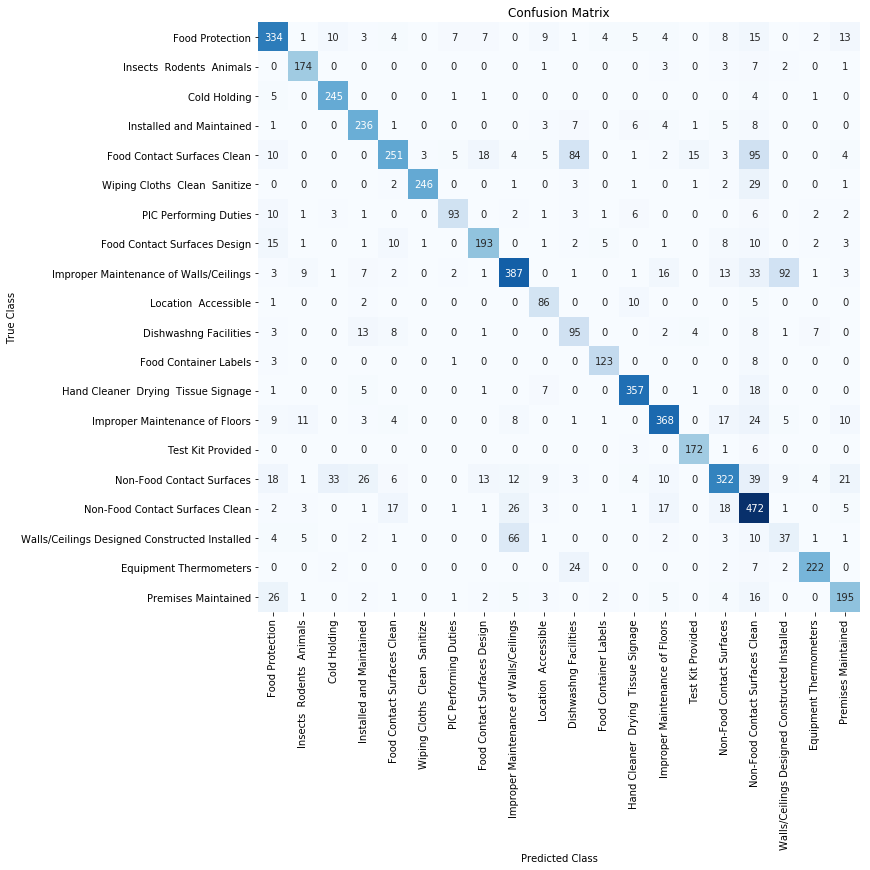

In [31]:
validate(model_nb, x_test, y_test)

#### Tuning the model with cross-validation
We can probably do better by trying out hyperparameter values other than the defaults, so we'll use a grid search with cross-validation to compare some options. For multinomial naive bayes, the only really meaningful hyperparameter is the alpha parameter (which controls smoothing), so we'll just search over that.

In [32]:
tuned_nb = GridSearchCV(model_nb,
                           param_grid={'alpha': [0.001,0.01,0.1,1,10,100]},
                           scoring='accuracy',
                           cv=5,
                           refit=True,
                           verbose=1)

tuned_nb.fit(x_train, y_train)

results = pd.DataFrame(tuned_nb.cv_results_).sort_values(by='rank_test_score').drop('params',axis=1)
print(results[:5].round(4).T)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    6.4s finished


                        3       2       1       0       4
mean_fit_time      0.1912  0.1949  0.1865  0.1785  0.1898
std_fit_time       0.0086  0.0124  0.0112   0.006   0.012
mean_score_time     0.024  0.0231  0.0227  0.0251  0.0206
std_score_time     0.0066  0.0055  0.0048  0.0095  0.0003
param_alpha             1     0.1    0.01   0.001      10
split0_test_score  0.7606  0.7568  0.7563  0.7552  0.7527
split1_test_score  0.7653  0.7703  0.7694  0.7675  0.7617
split2_test_score  0.7684  0.7687   0.764  0.7613  0.7629
split3_test_score  0.7678  0.7651  0.7662  0.7645  0.7563
split4_test_score  0.7672  0.7661  0.7639  0.7622  0.7677
mean_test_score    0.7659  0.7654   0.764  0.7621  0.7603
std_test_score     0.0028  0.0047  0.0043  0.0041  0.0053
rank_test_score         1       2       3       4       5


#### Evaluating the tuned model


Accuracy on hold-out set: 76.07726597325409%

                                               precision    recall  f1-score   support

                              Food Protection       0.75      0.78      0.77       427
                    Insects  Rodents  Animals       0.84      0.91      0.87       191
                                 Cold Holding       0.83      0.95      0.89       257
                     Installed and Maintained       0.78      0.87      0.82       272
                  Food Contact Surfaces Clean       0.82      0.50      0.62       500
               Wiping Cloths  Clean  Sanitize       0.98      0.86      0.92       286
                        PIC Performing Duties       0.84      0.71      0.77       131
                 Food Contact Surfaces Design       0.81      0.76      0.79       253
       Improper Maintenance of Walls/Ceilings       0.76      0.68      0.71       572
                         Location  Accessible       0.67      0.83      0.74      

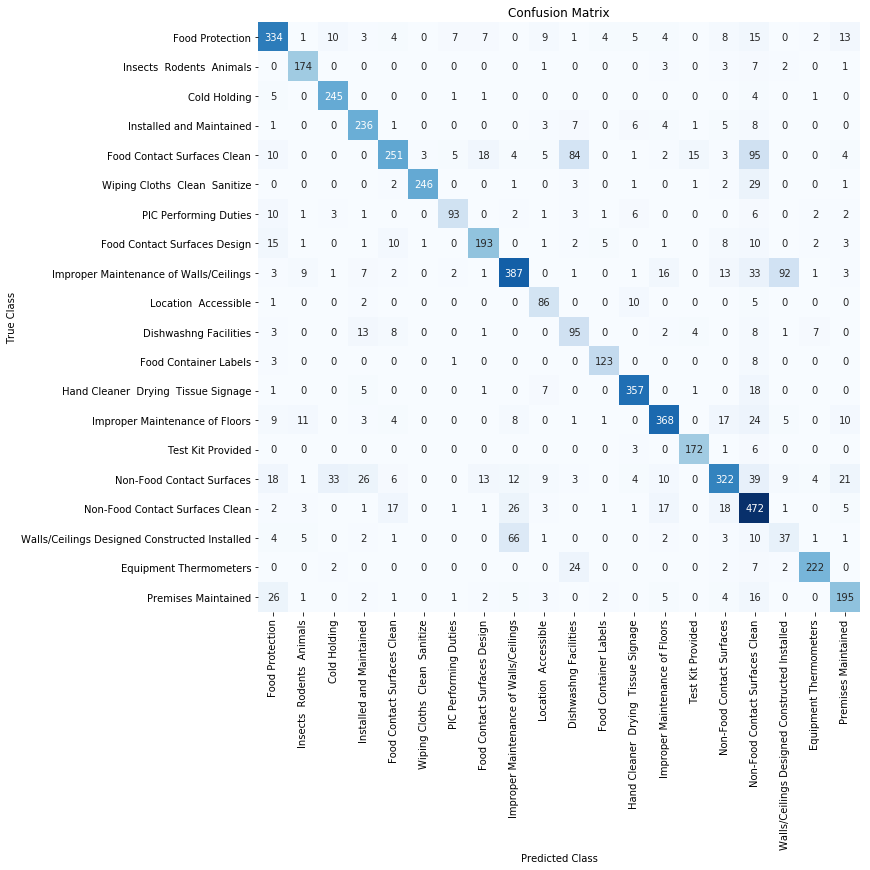

In [33]:
validate(tuned_nb, x_test, y_test)

## Trying out some other algorithms
We're not limited to Naive Bayes, fortunately. Let's look at how some other models perform by comparison. We'll do some basic tuning of each of these as well along the way.

#### Multinomial Logistic Regression (trained via Stochastic Gradient Descent)

In [34]:
tuned_lr = GridSearchCV(SGDClassifier(loss='log', penalty='l2'),
                           param_grid={'alpha': [0.00001,0.0001,0.001,0.01,0.1]},
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1,
                           refit=True,
                           verbose=1)

tuned_lr.fit(x_train, y_train)

results = pd.DataFrame(tuned_lr.cv_results_).sort_values(by='rank_test_score').drop('params',axis=1)
print(results[:5].round(4).T)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.2min finished


                        1        0       2       3       4
mean_fit_time       9.761  21.7964  7.2727  6.7951  6.2878
std_fit_time       0.2387   0.4624  0.1684  0.0788  0.1916
mean_score_time    0.0326   0.0311  0.0285  0.0268   0.029
std_score_time     0.0003   0.0058   0.007  0.0063  0.0082
param_alpha        0.0001    1e-05   0.001    0.01     0.1
split0_test_score   0.798   0.7975  0.7862  0.7156  0.5271
split1_test_score  0.8129   0.8041   0.792  0.7249  0.5375
split2_test_score  0.8146   0.8064  0.7959  0.7236  0.5179
split3_test_score  0.8133   0.8058  0.7951  0.7183  0.5266
split4_test_score  0.8168   0.8041  0.7961  0.7194  0.5272
mean_test_score    0.8111   0.8036  0.7931  0.7204  0.5272
std_test_score     0.0067   0.0032  0.0037  0.0034  0.0062
rank_test_score         1        2       3       4       5


Looking at top features

In [35]:
coefs = pd.DataFrame(tuned_lr.best_estimator_.coef_, index=sorted(y_train.unique()), columns=x_train.columns)
for i in coefs.index:
    print('Top Features for Category = {}: {}'.format(i,coefs.T[i].sort_values(ascending=False)[:10].index.format()))

Top Features for Category = Cold Holding: ['cheese', '41f', 'chicken', '50', 'proper_cold', '41', 'degree', '50f', 'cut', 'provide_proper']
Top Features for Category = Dishwashng Facilities: ['dishmachine', 'dishwasher', 'set', 'sink_provide', 'drain', 'bay', 'operating', 'dish', 'machine', 'missing']
Top Features for Category = Equipment Thermometers: ['thermometer', 'gauge', 'needed', 'working', 'refrigerator', 'internal', 'visible', 'temp', 'reach', 'dishmachine']
Top Features for Category = Food Contact Surfaces Clean: ['opener', 'knife', 'sanitizer', 'slicer', 'ppm', 'ice_machine', 'sanitizing', 'interior_ice', 'rinse', 'warewashing']
Top Features for Category = Food Contact Surfaces Design: ['scoop', 'cutting', 'grade', 'worn', 'discontinue_use', 'cracked', 'stained', 'stain', 'utensil', 'replace']
Top Features for Category = Food Container Labels: ['label', 'labeled', 'bottle', 'bulk', 'container', 'bin', 'several', 'multiple', 'storage_room', 'date']
Top Features for Category =

Evaluating performance


Accuracy on hold-out set: 81.62456661713719%

                                               precision    recall  f1-score   support

                              Food Protection       0.77      0.83      0.80       427
                    Insects  Rodents  Animals       0.92      0.90      0.91       191
                                 Cold Holding       0.92      0.94      0.93       257
                     Installed and Maintained       0.84      0.86      0.85       272
                  Food Contact Surfaces Clean       0.84      0.72      0.78       500
               Wiping Cloths  Clean  Sanitize       0.98      0.86      0.91       286
                        PIC Performing Duties       0.87      0.78      0.82       131
                 Food Contact Surfaces Design       0.89      0.79      0.83       253
       Improper Maintenance of Walls/Ceilings       0.58      0.90      0.70       572
                         Location  Accessible       0.79      0.88      0.84      

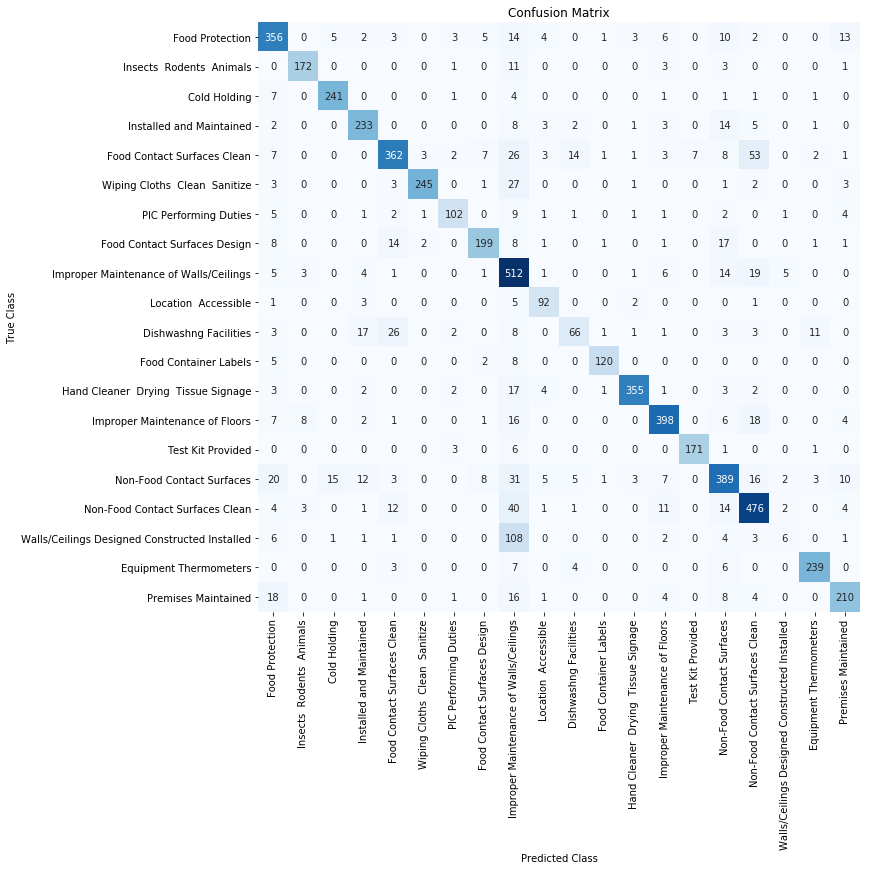

In [36]:
validate(tuned_lr, x_test, y_test)

#### Random Forests

In [37]:
tuned_rf = GridSearchCV(RandomForestClassifier(),
                           param_grid={
                                'n_estimators': [100,250],
                                'max_features': [0.02,0.05],
                                'max_leaf_nodes': [100,250]
                                },
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1,
                           refit=True,
                           verbose=1)

tuned_rf.fit(x_train, y_train)

results = pd.DataFrame(tuned_rf.cv_results_).sort_values(by='rank_test_score').drop('params',axis=1)
print(results[:5].round(4).T)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.8min finished


                           7       3        6       2        1
mean_fit_time         30.528  18.451  13.0179  7.4463  16.3818
std_fit_time          3.6452  0.2659   0.4919  0.1281    0.331
mean_score_time       0.4286  0.4668    0.195  0.2175   0.4998
std_score_time        0.0805   0.018   0.0184  0.0216   0.0516
param_max_features      0.05    0.02     0.05    0.02     0.02
param_max_leaf_nodes     250     250      250     250      100
param_n_estimators       250     250      100     100      250
split0_test_score     0.7675    0.77   0.7675  0.7697    0.745
split1_test_score     0.7749  0.7747   0.7719  0.7725   0.7538
split2_test_score     0.7772   0.775   0.7772  0.7745    0.755
split3_test_score     0.7822  0.7833   0.7808  0.7805   0.7543
split4_test_score     0.7757  0.7741   0.7738  0.7716   0.7526
mean_test_score       0.7755  0.7754   0.7742  0.7737   0.7521
std_test_score        0.0047  0.0043   0.0045  0.0037   0.0037
rank_test_score            1       2        3       4  

In [38]:
imps = pd.DataFrame([x_train.columns, tuned_rf.best_estimator_.feature_importances_]).T
imps = pd.DataFrame(imps.values,columns=['name','importance']).set_index('name').importance
print('Most important features: {}'.format(imps.sort_values(ascending=False)[:25]))

Most important features: name
floor             0.052171
clean            0.0473827
thermometer      0.0388567
hood             0.0264322
wall             0.0236623
clean_floor      0.0197247
ceiling          0.0196497
repair           0.0184231
towel            0.0174537
cloth            0.0172986
wiping           0.0169999
test             0.0169418
label            0.0168707
41f              0.0161623
wiping_cloth      0.014638
food             0.0144837
test_kit         0.0132268
kit              0.0123926
cutting          0.0120863
hand             0.0113094
paper             0.011245
soap             0.0111818
paper_towel       0.011033
cutting_board    0.0105329
interior         0.0103945
Name: importance, dtype: object



Accuracy on hold-out set: 78.20703318474493%

                                               precision    recall  f1-score   support

                              Food Protection       0.70      0.83      0.76       427
                    Insects  Rodents  Animals       0.92      0.86      0.89       191
                                 Cold Holding       0.87      0.91      0.89       257
                     Installed and Maintained       0.84      0.82      0.83       272
                  Food Contact Surfaces Clean       0.83      0.67      0.74       500
               Wiping Cloths  Clean  Sanitize       0.96      0.85      0.90       286
                        PIC Performing Duties       0.93      0.63      0.75       131
                 Food Contact Surfaces Design       0.88      0.77      0.82       253
       Improper Maintenance of Walls/Ceilings       0.77      0.87      0.82       572
                         Location  Accessible       0.70      0.80      0.75      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


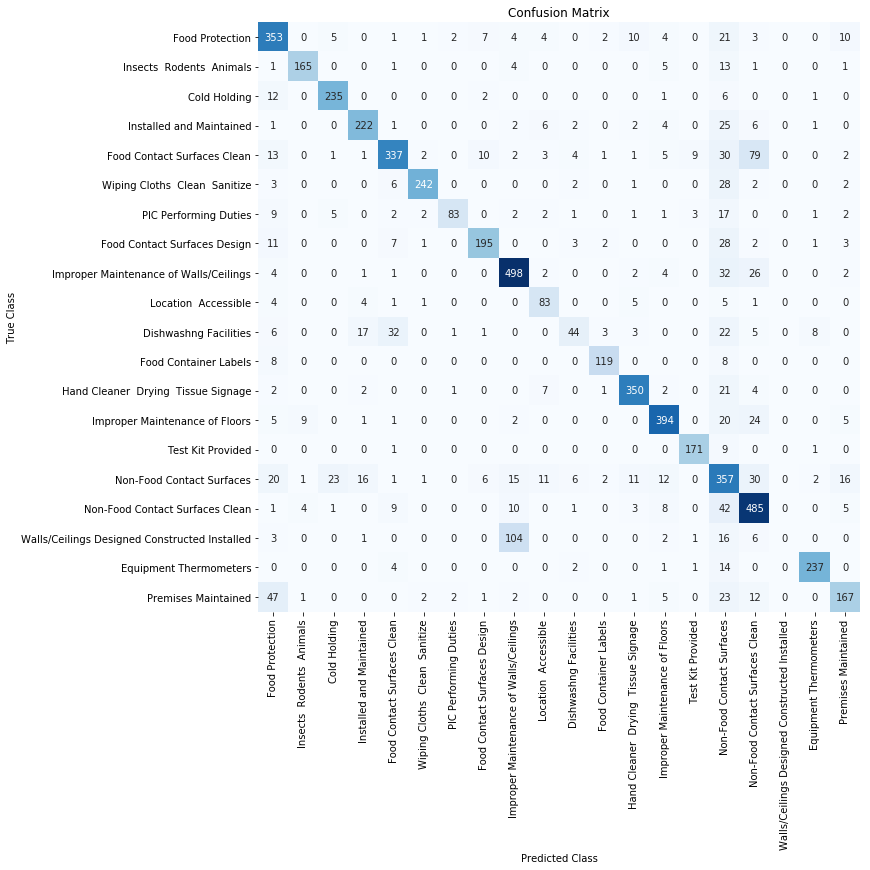

In [39]:
validate(tuned_rf, x_test, y_test)

## Testing out on some new examples

This is an example of how you might create a simple service that uses the trained model to parse and categorize new text. It's actually a bit too simple for real use (it doesn't remove stop words or do lemmatization, for example), but it works for this illustration, and you should be able add those things in yourself - just repeat the additional parsing steps used above for the training data on the new text here.


In [0]:
def test_model(text):
    x = vectorizer.transform([text]).todense()
    print('Predicted category: {}\n'.format(tuned_lr.predict(x)[0]))
    print(pd.DataFrame(tuned_lr.predict_proba(x),columns=sorted(y_train.unique())).round(2).T)

In [41]:
test_model('the ice machine is dirty')

Predicted category: Food Contact Surfaces Clean

                                                  0
Cold Holding                                   0.01
Dishwashng Facilities                          0.01
Equipment Thermometers                         0.01
Food Contact Surfaces Clean                    0.51
Food Contact Surfaces Design                   0.13
Food Container Labels                          0.00
Food Protection                                0.18
Hand Cleaner  Drying  Tissue Signage           0.00
Improper Maintenance of Floors                 0.03
Improper Maintenance of Walls/Ceilings         0.03
Insects  Rodents  Animals                      0.00
Installed and Maintained                       0.01
Location  Accessible                           0.00
Non-Food Contact Surfaces                      0.01
Non-Food Contact Surfaces Clean                0.02
PIC Performing Duties                          0.02
Premises Maintained                            0.00
Test Kit Provid

In [42]:
test_model('the bathroom is out of paper towels and hand soap')

Predicted category: Hand Cleaner  Drying  Tissue Signage

                                                  0
Cold Holding                                   0.01
Dishwashng Facilities                          0.00
Equipment Thermometers                         0.00
Food Contact Surfaces Clean                    0.00
Food Contact Surfaces Design                   0.01
Food Container Labels                          0.00
Food Protection                                0.00
Hand Cleaner  Drying  Tissue Signage           0.89
Improper Maintenance of Floors                 0.00
Improper Maintenance of Walls/Ceilings         0.01
Insects  Rodents  Animals                      0.01
Installed and Maintained                       0.01
Location  Accessible                           0.00
Non-Food Contact Surfaces                      0.00
Non-Food Contact Surfaces Clean                0.01
PIC Performing Duties                          0.01
Premises Maintained                            0.01
Test K

In [43]:
test_model('rodent droppings in the basement')

Predicted category: Insects  Rodents  Animals

                                                  0
Cold Holding                                   0.03
Dishwashng Facilities                          0.01
Equipment Thermometers                         0.02
Food Contact Surfaces Clean                    0.01
Food Contact Surfaces Design                   0.02
Food Container Labels                          0.01
Food Protection                                0.02
Hand Cleaner  Drying  Tissue Signage           0.02
Improper Maintenance of Floors                 0.05
Improper Maintenance of Walls/Ceilings         0.04
Insects  Rodents  Animals                      0.62
Installed and Maintained                       0.02
Location  Accessible                           0.00
Non-Food Contact Surfaces                      0.01
Non-Food Contact Surfaces Clean                0.02
PIC Performing Duties                          0.01
Premises Maintained                            0.03
Test Kit Provided

In [46]:
test_model('ceiling leak and mold in bathroom')

Predicted category: Improper Maintenance of Walls/Ceilings

                                                  0
Cold Holding                                   0.01
Dishwashng Facilities                          0.00
Equipment Thermometers                         0.01
Food Contact Surfaces Clean                    0.00
Food Contact Surfaces Design                   0.00
Food Container Labels                          0.01
Food Protection                                0.03
Hand Cleaner  Drying  Tissue Signage           0.03
Improper Maintenance of Floors                 0.00
Improper Maintenance of Walls/Ceilings         0.60
Insects  Rodents  Animals                      0.00
Installed and Maintained                       0.13
Location  Accessible                           0.00
Non-Food Contact Surfaces                      0.00
Non-Food Contact Surfaces Clean                0.01
PIC Performing Duties                          0.01
Premises Maintained                            0.00
Test

In [45]:
test_model('missing thermometer for walk-in freezer')

Predicted category: Equipment Thermometers

                                                  0
Cold Holding                                   0.01
Dishwashng Facilities                          0.00
Equipment Thermometers                         0.82
Food Contact Surfaces Clean                    0.00
Food Contact Surfaces Design                   0.00
Food Container Labels                          0.00
Food Protection                                0.04
Hand Cleaner  Drying  Tissue Signage           0.00
Improper Maintenance of Floors                 0.01
Improper Maintenance of Walls/Ceilings         0.01
Insects  Rodents  Animals                      0.00
Installed and Maintained                       0.00
Location  Accessible                           0.00
Non-Food Contact Surfaces                      0.07
Non-Food Contact Surfaces Clean                0.02
PIC Performing Duties                          0.00
Premises Maintained                            0.00
Test Kit Provided   